#This Notebook is based of of Martian/Lunar Crater Detection Dataset from Kaggle by Ben Manor https://www.kaggle.com/code/benmanor/crater-object-detection-using-faster-rcnn

In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!kaggle datasets download -d lincolnzh/martianlunar-crater-detection-dataset
!unzip martianlunar-crater-detection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/lincolnzh/martianlunar-crater-detection-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 73.0M/74.0M [00:01<00:00, 63.0MB/s]
100% 74.0M/74.0M [00:01<00:00, 61.6MB/s]
Archive:  martianlunar-crater-detection-dataset.zip
  inflating: best.pt                 
  inflating: craters/test/images/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg  
  inflating: craters/test/images/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg  
  inflating: craters/test/images/019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg  
  inflating: craters/test/images/04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg  
  inflating: craters/test/images/mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg  
  inflating: craters/test/images/mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg  
  inflating: craters/test/images/mars_crater--116-_jpg.rf.2e550a693a8800808e68848484716b95.jpg  
  inflating: craters/test/images/mars_crater--117-_jpg.rf.b

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python

#Copy and unify the train and validation database into one folder for images and another for labels
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/images/. ./images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/. ./images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/labels/. ./labels/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/labels/. ./labels/

Cloning into 'vision'...
remote: Enumerating objects: 578081, done.
remote: Counting objects: 100% (25867/25867), done.
remote: Compressing objects: 100% (1484/1484), done.
remote: Total 578081 (delta 24238), reused 25794 (delta 24201), pack-reused 552214 (from 1)
Receiving objects: 100% (578081/578081), 1.08 GiB | 23.24 MiB/s, done.
Resolving deltas: 100% (540331/540331), done.
fatal: not a git repository (or any of the parent directories): .git
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ase_1xbu
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ase_1xbu
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=376057 sha256=fa9c556723344f9e66c10fff13fd013a7668c4760a2c1021dbc511452942873e
  Stored in directory:

In [ ]:
!pip install pycocotools --upgrade

In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

In [ ]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Crater']

    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            labels_np = labels.numpy().tolist()
            # Pass bounding boxes and labels to Albumentations
            sample = self.transforms(image=img, bboxes=target['boxes'], labels=labels_np)
            img = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(sample['labels'], dtype=torch.int64)

        # Ensure boxes are valid after transformation
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.imgs)



In [ ]:
def get_model_bbox(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='r',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='red', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

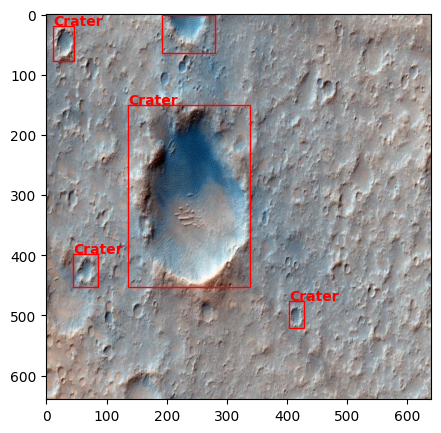

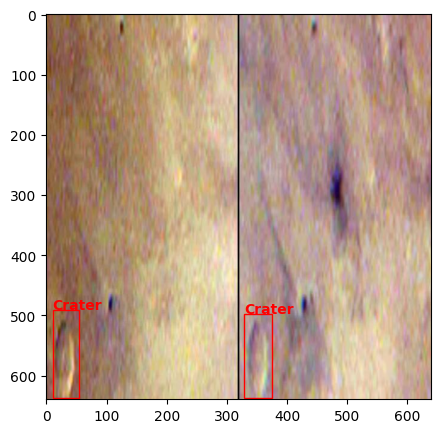

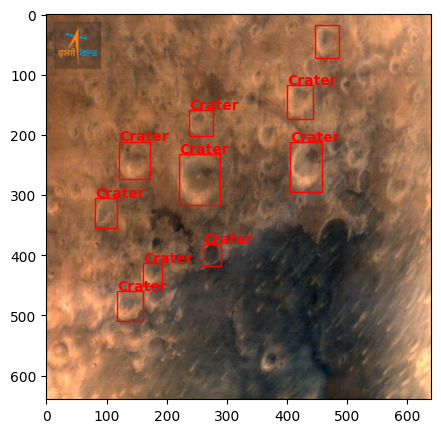

In [ ]:
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

<a id="K-fold"></a>
# K-fold cross validation

One of the drawbacks of a small database is that it's problematic to rely on the evaluation of the trained model on the  validation dataset either selected manually or randomly.
The issue is that it's hard to estimate if the validation dataset that was selected is biased towards or against the training dataset. statistically with a large database that is less likely to happen but with our database it's hard to guarantee.

For this reason I chose to perform K-fold validation with 5 folds, which will randomly split the dataset(train and validation) 5 times, each time training 50 epochs and average the resulting metrics from each fold, raisining the confidence that a certain setup hyperparamters and configurations are advantageous or not.

over 14 diffrent configurations of optimizers, augmentations, batch sizes and freezing diffrent layers were attempted.
The following table summerises the 8 best configurations tested using K-fold cross validation.
The performance was rated according to two popular COCO metrics: mAP @ IoU:0.5 and mAP@IoU:0.5:0.95


![image.png](attachment:c1343f24-523f-4740-b2a3-d5a746dae546.png)


Thus, SGD with no weight decay,using resnet-v2, 5 folds, 50 epochs and a batch size of 8 was the settings selected.
Due to the issue mentioned previously though, resnet V1 was used in this notebook as torchvision 0.13 which includes resnet-v2 failed to install

As can be seen by the previous table, it is surprising that augmentations did not provide any improvment in the selected matrics, in addition the overall scoring results were surprisengly low.
My first assumtion to the cause of the latter was that the database size was too small to provide enough generalization in the classification capabilities of the model. Augmenation however was supposed to help in the matter, not be detrimental.
Upon closer analysis, especially displaying the labeld boundry boxes over the images showed that there is more work to be had on the labeling of the crater images. I cannot tell with confidence but one can see many cases of objects that weren't labeled as craters next to identical ones that were, as well as labels which to the untrained eye do not seem like craters.

This would definatvly lower the success metrics of any model to be trained, as predictions on craters which might be correct will be returned to the model as false positive and mislabeled boxes as craters will return false negative to the model, causing the parametrs to be adjusted incorrectly.

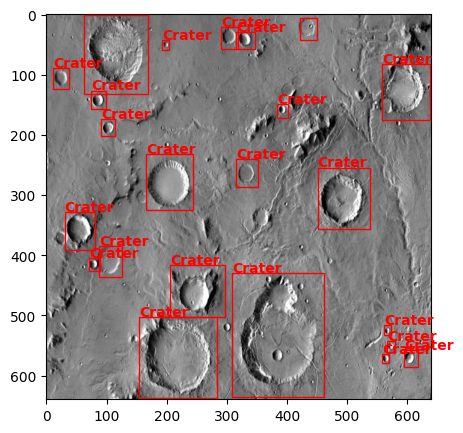

--------------------------------
FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/13]  eta: 0:00:35  lr: 0.000421  loss: 1.8138 (1.8138)  loss_classifier: 0.8217 (0.8217)  loss_box_reg: 0.3097 (0.3097)  loss_objectness: 0.6497 (0.6497)  loss_rpn_box_reg: 0.0328 (0.0328)  time: 2.7555  data: 0.9589  max mem: 7212
Epoch: [0]  [12/13]  eta: 0:00:01  lr: 0.005000  loss: 1.0640 (1.1784)  loss_classifier: 0.4580 (0.4786)  loss_box_reg: 0.3142 (0.3390)  loss_objectness: 0.1659 (0.3183)  loss_rpn_box_reg: 0.0433 (0.0425)  time: 1.4907  data: 0.1020  max mem: 7372
Epoch: [0] Total time: 0:00:19 (1.4979 s / it)
Epoch: [1]  [ 0/13]  eta: 0:00:25  lr: 0.005000  loss: 0.7018 (0.7018)  loss_classifier: 0.2133 (0.2133)  loss_box_reg: 0.3784 (0.3784)  loss_objectness: 0.0846 (0.0846)  loss_rpn_box_reg: 0.0255 (0.0255)  time: 1.9886  data: 0.5157  max mem: 7372
Epoch: [1]  [12/13]  eta: 0:00:01  lr: 0.005000  loss: 0.7018 (0.6653)  loss_classifier: 0.2133 (0.2142)  loss_box_reg: 0.3139 (0.3297)  loss_objectness: 0.0774 (0.0778)  loss_rpn_box_reg: 0.0273 (0.0436)  tim

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
k_folds = 5
num_epochs = 1


# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
dataset_val = CraterDataset('/contentcraters/valid', get_transform(train=False))

# Prints an example of image with annotations
img, target = dataset[1]
plot_img_bbox(img, target)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)

    #model.apply(reset_weights) # Check if beneficial

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                momentum=0.9, weight_decay=0)
    # optimizer = torch.optim.NAdam(params, lr=0.001,  # Check if beneficial
    #                             weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=20,
                                                    gamma=0.2)

    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

# Training Time


In [ ]:
!mkdir /content/bestEpochs

In [ ]:
# !mkdir /content/drive/MyDrive/bestEpochs

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 200

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
dataset_val = CraterDataset('/content/craters/valid', get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_bbox(num_classes)

'''
Use this to reset all trainable weights
model.apply(reset_weights)
'''

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,  # Feel free to play with values
                            momentum=0.9, weight_decay=0)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.2)


result_mAP = []
best_epoch = None
# Let's train!
for epoch in range(num_epochs):


    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results =  evaluate(model, data_loader_val, device=device)
    # saves results of mAP @ IoU = 0.5
    result_mAP.append(results.coco_eval['bbox'].stats[1])
    #save the best result so far
    if result_mAP[-1] == max(result_mAP):
        best_save_path = os.path.join(f'/content/drive/MyDrive/bestEpochs/Crater_bestmodel_noaug_sgd(wd=0)_8batch-epoch{epoch}.pth')
        torch.save(model.state_dict(), best_save_path)
        best_epoch = int(epoch)
        print(f'model from epoch number {epoch} saved!\n result is {max(result_mAP)}')

# Saving the last model
save_path = os.path.join(f'Crater_noaug_sgd_2batch-lastepoch{num_epochs-1}.pth')
torch.save(model.state_dict(), save_path)
print(f'model from last epoch(no.{num_epochs-1}) saved')

Epoch: [0]  [ 0/13]  eta: 0:00:30  lr: 0.000421  loss: 1.5467 (1.5467)  loss_classifier: 0.5045 (0.5045)  loss_box_reg: 0.4398 (0.4398)  loss_objectness: 0.5704 (0.5704)  loss_rpn_box_reg: 0.0319 (0.0319)  time: 2.3609  data: 0.3766  max mem: 11048
Epoch: [0]  [12/13]  eta: 0:00:01  lr: 0.005000  loss: 0.9829 (1.0970)  loss_classifier: 0.3758 (0.3868)  loss_box_reg: 0.3615 (0.3660)  loss_objectness: 0.1779 (0.3028)  loss_rpn_box_reg: 0.0372 (0.0414)  time: 1.4092  data: 0.0589  max mem: 11207
Epoch: [0] Total time: 0:00:18 (1.4165 s / it)
creating index...
index created!
Test:  [ 0/26]  eta: 0:00:10  model_time: 0.1554 (0.1554)  evaluator_time: 0.0752 (0.0752)  time: 0.3956  data: 0.1623  max mem: 11207
Test:  [25/26]  eta: 0:00:00  model_time: 0.0747 (0.0784)  evaluator_time: 0.0131 (0.0227)  time: 0.1053  data: 0.0078  max mem: 11207
Test: Total time: 0:00:03 (0.1197 s / it)
Averaged stats: model_time: 0.0747 (0.0784)  evaluator_time: 0.0131 (0.0227)
Accumulating evaluation results..

#Inference

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset_test = CraterDataset('/content/craters/test', get_transform(train=False))


data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_bbox(num_classes)


# load model to evaluate
model.load_state_dict(torch.load(os.path.join(f'/contet/bestEpochs/Crater_bestmodel_noaug_sgd(wd=0)_8batch-epoch{best_epoch}.pth'),map_location=device))
model.to(device)


evaluate(model, data_loader_test, device=device)

In [ ]:
color_inference = np.array([0.0,0.0,255.0])
color_label = np.array([255.0,0.0,0.0])

detection_threshold = 0.7
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

In [ ]:
for i,data in enumerate(data_loader_test):
    # get the image file name for predictions file name
    image_name = 'image no:' + str(int(data[1][0]['image_id']))
    model_image = data[0][0]
    cv2_image = np.transpose(model_image.numpy()*255,(1, 2, 0)).astype(np.float32)
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR).astype(np.float32)

    # add batch dimension
    model_image = torch.unsqueeze(model_image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(model_image.to(device))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = np.round(scores[scores >= detection_threshold],2)
        draw_boxes = boxes.copy()


        # draw the bounding boxes and write the class name on top of it
        for j,box in enumerate(draw_boxes):
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_inference, 2)
            cv2.putText(img=cv2_image, text="Crater",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)
            cv2.putText(img=cv2_image, text=str(scores[j]),
                        org=(int(box[0]), int(box[1] + 8)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)

        # add boxes for labels
        for box in data[1][0]['boxes']:
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_label, 2)
            cv2.putText(img=cv2_image, text="Label",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_label,
                        thickness=1, lineType=cv2.LINE_AA)


        # set size
        plt.figure(figsize=(10,10))
        plt.axis("off")

        # convert color from CV2 BGR back to RGB
        plt_image = cv2.cvtColor(cv2_image/255.0, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
        plt.show()
        cv2.imwrite(f"{colab_path}/Results/{image_name}.jpg", cv2_image)
    print(f"Image {i + 1} done...")
    print('-' * 50)
print('TEST PREDICTIONS COMPLETE')

avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


# This next portion will show how to use a mask-RCNN essentially the exact same except with a few key differences


In [ ]:
!kaggle datasets download aryashah2k/yolo-v11-tumor-detection-data-roboflow

In [ ]:
!unzip yolo-v11-tumor-detection-data-roboflow.zip

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import numpy as np
import json
from PIL import Image
from pycocotools.coco import COCO
from engine import train_one_epoch, evaluate
import utils

Our dataset loader is specifically only for a Yolo formmatted dataset. In this code we are also not using albementations. Instead we will use torchvision.transforms and because of this you can see that we use tv_tensor for changing our targets to tensors. If you dont use this its a possibility that when you apply transformations you will either get no errors and no transfmormations or it will error out.

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from shapely.geometry import Polygon
from shapely.geometry import box as shapely_box
from shapely import speedups
from PIL import ImageDraw

# Enable Shapely speedups if available
if speedups.available:
    speedups.enable()

import os
import torch
import numpy as np
from PIL import Image, ImageDraw
from torchvision.io import read_image
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors

class YoloDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        """
        Args:
            imgs_dir (str): Directory where the images are stored.
            anns_dir (str): Directory where the YOLO annotation files are stored.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms
        self.classes = ['NO_tumor', 'glioma', 'meningioma', 'pituitary', 'space-occupying lesion-']

        # Get all image files
        self.img_files = [file_name for file_name in os.listdir(imgs_dir)
                          if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.img_files.sort()

    def __getitem__(self, idx):
        # Get image file name and corresponding annotation file
        img_file = self.img_files[idx]
        img_path = os.path.join(self.imgs_dir, img_file)
        ann_path = os.path.join(self.anns_dir, os.path.splitext(img_file)[0] + '.txt')

        # Load the image
        img = read_image(img_path)
        img = tv_tensors.Image(img)

        # Get image dimensions
        img_height, img_width = F.get_size(img)  # returns (H, W)

        # Initialize lists for boxes, labels, masks
        boxes = []
        labels = []
        masks = []

        # Check if annotation file exists
        if os.path.exists(ann_path):
            with open(ann_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue  # Skip invalid lines

                    class_id = int(parts[0])

                    if len(parts) == 5:
                        # Standard YOLO format: class_id x_center y_center width height
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        # Convert from normalized coordinates to pixel coordinates
                        x_center *= img_width
                        y_center *= img_height
                        width *= img_width
                        height *= img_height

                        # Convert from center coordinates to corner coordinates
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2

                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)

                        # Create a mask from the bounding box
                        mask = torch.zeros((img_height, img_width), dtype=torch.uint8)
                        x_min_int = int(round(x_min))
                        y_min_int = int(round(y_min))
                        x_max_int = int(round(x_max))
                        y_max_int = int(round(y_max))
                        mask[y_min_int:y_max_int, x_min_int:x_max_int] = 1
                        masks.append(mask.numpy())
                    else:
                        # Assume the rest of the parts are polygon coordinates
                        # Format: class_id x1 y1 x2 y2 x3 y3 ... xn yn
                        coords = list(map(float, parts[1:]))
                        if len(coords) % 2 != 0:
                            continue  # Invalid polygon

                        x_coords = coords[::2]
                        y_coords = coords[1::2]

                        # Convert normalized coordinates to pixel coordinates
                        x_coords = [x * img_width for x in x_coords]
                        y_coords = [y * img_height for y in y_coords]

                        # Create a polygon
                        polygon = [(x, y) for x, y in zip(x_coords, y_coords)]

                        # Create a mask from the polygon
                        mask_img = Image.new('L', (img_width, img_height), 0)
                        ImageDraw.Draw(mask_img).polygon(polygon, outline=1, fill=1)
                        mask = np.array(mask_img, dtype=np.uint8)
                        masks.append(mask)

                        # Compute bounding box
                        x_min = min(x_coords)
                        x_max = max(x_coords)
                        y_min = min(y_coords)
                        y_max = max(y_coords)
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)

        else:
            # If annotation file doesn't exist, return empty annotations
            boxes = []
            labels = []
            masks = []

        # Convert to tensors
        if len(boxes) > 0:
            boxes = tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=F.get_size(img))
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = tv_tensors.Mask(masks)
            # Compute area
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            area = torch.as_tensor(area, dtype=torch.float32)
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        else:
            boxes = tv_tensors.BoundingBoxes([], format='XYXY', canvas_size=F.get_size(img))
            labels = torch.as_tensor([], dtype=torch.int64)
            masks = tv_tensors.Mask([])
            area = torch.as_tensor([], dtype=torch.float32)
            iscrowd = torch.as_tensor([], dtype=torch.int64)

        image_id = idx

        # Prepare the target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }


        # Apply transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_files)



note: small datasets and biased datasets can sometimes get really good results on a specific class but horrible on others this is where the transformations can really come in handy.

In [ ]:
from torchvision.transforms import v2 as T

# works similarly to albementations as it applies transformations to all targets
def get_transform(train):
    transforms = []
    if train:
        # transforms.append(T.RandomHorizontalFlip(.2))
        # transforms.append(T.RandomVerticalFlip(.5))
        # transforms.append(T.RandomRotation(180))
        transforms.append(T.Resize(320))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
dataset = YoloDataset(imgs_dir='/content/YOLOdataset/test/images',
                                    anns_dir='/content/YOLOdataset/test/labels',transforms=get_transform(train=False))

In [ ]:
print(len(dataset))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def display_image_and_annotations(dataset, idx):
    # Get the image and target from the dataset at index `idx`
    img, target = dataset[idx]

    if isinstance(img, torch.Tensor):
        img_np = img.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]
    else:
        # If it's a PIL Image, convert to NumPy directly
        img_np = np.array(img)

    # Get image dimensions
    height, width = img_np.shape[:2]

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # Display the image
    ax.imshow(img_np)

    # Get the bounding boxes (convert tensor to NumPy array)
    boxes = target["boxes"].numpy()

    # Get the labels (convert tensor to NumPy array)
    labels = target["labels"].numpy()

    # Get the class names from the dataset
    class_names = dataset.classes

    # Add bounding boxes and class names to the plot
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Get the class name
        class_name = class_names[label]

        # Add class name text above the bounding box
        ax.text(
            x1,
            y1 - 10,  # Slightly above the bounding box
            class_name,
            fontsize=12,
            color='red',
            bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none', pad=2)
        )

    # Get the masks (ensure masks are tensors and convert to NumPy array)
    masks = target["masks"].numpy()

    # Overlay each mask on the image with transparency
    for mask in masks:
        ax.imshow(np.ma.masked_where(mask == 0, mask), cmap='jet', alpha=0.5)

    # Add axis labels
    ax.set_xlabel(f"Width (pixels): {width}")
    ax.set_ylabel(f"Height (pixels): {height}")

    # Add tick marks to visualize the dimensions
    ax.set_xticks(np.arange(0, width, width // 10))  # Set ticks for width
    ax.set_yticks(np.arange(0, height, height // 10))  # Set ticks for height

    # Display the plot
    plt.axis('on')
    plt.show()

# Now you can call the function with your dataset and index
display_image_and_annotations(dataset, idx=83)


In [ ]:
#######################################################################
# Check to make sure you have the right classes                        #
# NOTE: if you dont have a background class uncomment out +1           #
#######################################################################
# Get the number of classes
num_classes = len(dataset.classes) #+1
print(f"Number of classes: {num_classes}")

# Get the class names
class_names = dataset.classes
print("Class names:", class_names)

Function to retrieve new model. Same proccess here as faster-rcnn. Mask-RCNN is the same model as Faster-RCNN except instead of two heads it now has 3 by adding a mask prediction model.

![Mask-RCNN Model](https://www.researchgate.net/publication/358697875/figure/fig1/AS:1127591259979777@1645850114571/The-mask-R-CNN-network-architecture-The-mask-R-CNN-regional-convolutional-neural.png)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    # # Set requires_grad based on your fine-tuning strategy
    # for param in model.parameters():
    #     param.requires_grad = False  # Freeze all layers except for the following

    # # Train only the ROI heads, box predictor, and mask predictor
    # for param in model.roi_heads.parameters():
    #     param.requires_grad = True

    # for param in model.roi_heads.box_predictor.parameters():
    #     param.requires_grad = True

    # for param in model.roi_heads.mask_predictor.parameters():
    #     param.requires_grad = True

    # # Fine-tuning specific layers of the RPN
    # rpn_layers = list(model.rpn.children())  # Get all layers in the RPN as a list

    # # Set requires_grad = True for only the last N layers (you can adjust N as needed)
    # fine_tune_last_n_layers = 2  # Change this number to control how many layers you want to fine-tune
    # for layer in rpn_layers[-fine_tune_last_n_layers:]:
    #     for param in layer.parameters():
    #         param.requires_grad = True

    return model


In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

dataset_test = YoloDataset(imgs_dir='/content/YOLOdataset/valid/images',
                                    anns_dir='/content/YOLOdataset/valid/labels',transforms=get_transform(train=True))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=10,
    shuffle=False,
    collate_fn=utils.collate_fn
)



evaluate(model, data_loader_test, device=device)



In [ ]:
#Change this if you want to save the model to your drive otherwise it will save only in this session
!mkdir /content/epchs
epchs_dir = '/content/epchs'

This version of the training loop has a few differences from the one before with added features like using ReduceLRonPlateu and as well as using early stopping. The implementation would be the same with the faster RCNN if you would like to use them there to.


In [ ]:


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 5 sine we have 4 classes +1 for background
num_classes = 5
# use our dataset and defined transformations
dataset = YoloDataset(imgs_dir='/content/YOLOdataset/train/images',anns_dir='/content/YOLOdataset/train/labels',transforms=get_transform(train=True))
dataset_val= YoloDataset(imgs_dir='/content/YOLOdataset/valid/images', anns_dir='/content/YOLOdataset/valid/labels',transforms=get_transform(train=False))

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=10,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# optimizer = torch.optim.Adam(
#     params,
#     lr=0.005,
#     weight_decay=0.0005,

# )


lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='max',   # Since we're maximizing mAP
#     factor=0.1,   # Factor by which the learning rate will be reduced
#     patience=5,   # Number of epochs to wait before reducing LR if no improvement
#     threshold=0.01,  # Minimum improvement to consider as an improvement
#     verbose=True   # Prints a message when the learning rate is reduced
# )

# let's train it just for 2 epochs
num_epochs = 100
result_mAP = []
best_epoch = None

#Patience for early stopping and counter variable for it

early_stopping_patience = 10
epochs_no_improvement = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate


    #this is for using StepLR schedular comment it out if you want to use ReduceLRonPlateu and uncomment the other one
    lr_scheduler.step()

    # evaluate on the test dataset
    results =  evaluate(model, data_loader_val, device=device)

    result_mAP.append(results.coco_eval['bbox'].stats[1])

    #save the best result so far
    if result_mAP[-1] == max(result_mAP):
        epochs_no_improvement = 0
        best_save_path = os.path.join(f'{epchs_dir}/MRCNN_bestmodel(wd=0)_8batch-epoch{epoch}.pth')
        torch.save(model.state_dict(), best_save_path)
        best_epoch = int(epoch)
        print(f'model from epoch number {epoch} saved!\n result is {max(result_mAP)}')
    else:
      epochs_no_improvement += 1
    if epochs_no_improvement >= early_stopping_patience:
          print(f"Early stopping triggered. No improvement in {early_stopping_patience} epochs.")
          print(f"Best epoch: {best_epoch}")
          print(f"Best mAP: {max(result_mAP)}")
          break
    else:
      epochs_no_improvement += 1
    if epochs_no_improvement >= early_stopping_patience:
          print(f"Early stopping triggered. No improvement in {early_stopping_patience} epochs.")
          print(f"Best epoch: {best_epoch}")
          print(f"Best mAP: {max(result_mAP)}")
          break
    #This is for if your using reduce learningRateonPlateu
    #lr_scheduler.step(current_mAP)

print("That's it!")

In [ ]:
print(best_epoch)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 5
# use our dataset and defined transformations
dataset_test= YoloDataset(imgs_dir='/content/YOLOdataset/test/images', anns_dir='/content/YOLOdataset/test/labels',transforms=get_transform(train=False))


data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)


# load model to evaluate
model.load_state_dict(torch.load(os.path.join(f'{epchs_dir}/MRCNN_bestmodel(wd=0)_8batch-epoch{best_epoch}.pth'),map_location=device))
model.to(device)

evaluate(model, data_loader_test, device=device)

In [ ]:
color_inference = np.array([0.0,0.0,255.0])
color_label = np.array([255.0,0.0,0.0])

detection_threshold = 0.7
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

In [ ]:

#create a directory to out put the results which will be side by side comparisons of groundtruth and predictions
!mkdir /content/Test/images
Results_dir = '/content/Test/images'

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import numpy as np
import torch
from PIL import Image



# Example class mapping from IDs to class names
class_names = dataset_test.classes
class_mapping = {i: name for i, name in enumerate(class_names)}

# Define colors for inference and labels
color_inference = (0, 0, 255)  # Blue for inference as a tuple (R, G, B)
color_label = (255, 0, 0)      # Red for ground truth

# Detection threshold
detection_threshold = 0.5

# Loop through the dataset
model.eval()
for idx, data in enumerate(dataset_test):
    image, target = data

    # Prepare the image for model input
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        predictions = model(x)
        pred = predictions[0]

    # Normalize image for drawing
    original_image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    original_image = original_image[:3, ...]

    # Filter predictions based on detection threshold
    filtered_indices = pred["scores"] >= detection_threshold
    filtered_boxes = pred["boxes"][filtered_indices]
    filtered_labels = pred["labels"][filtered_indices]
    filtered_scores = pred["scores"][filtered_indices]
    filtered_masks = pred["masks"][filtered_indices]

    # Map predicted labels to class names and format labels
    pred_labels = [f"{class_mapping[label.item()]}: {score:.3f}" for label, score in zip(filtered_labels, filtered_scores)]

    # Repeat the color for all bounding boxes
    colors = [color_inference] * len(filtered_boxes)

    # Draw bounding boxes and labels for predictions
    output_image_pred = draw_bounding_boxes(original_image.clone(), filtered_boxes.long(), labels=pred_labels, colors=colors)

    # Draw segmentation masks for predictions
    masks = (filtered_masks > 0.7).squeeze(1)
    output_image_pred = draw_segmentation_masks(output_image_pred, masks, alpha=0.5, colors=colors)

    # Ground truth boxes and masks
    gt_boxes = target['boxes']
    gt_labels = target['labels']
    gt_masks = target['masks']

    # Map ground truth labels to class names
    gt_labels_formatted = [class_mapping[label.item()] for label in gt_labels]

    # Draw bounding boxes and labels for ground truth
    output_image_gt = draw_bounding_boxes(original_image.clone(), gt_boxes.long(), labels=gt_labels_formatted, colors=[color_label] * len(gt_boxes))

    # Draw segmentation masks for ground truth
    gt_masks = gt_masks.squeeze(1).to(torch.bool)
    output_image_gt = draw_segmentation_masks(output_image_gt, gt_masks, alpha=0.5, colors=[color_label] * len(gt_boxes))

    # Display the images side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Ground truth image
    ax[0].imshow(output_image_gt.permute(1, 2, 0))
    ax[0].axis('off')
    ax[0].set_title(f"Ground Truth - Image {idx + 1}")

    # Prediction image
    ax[1].imshow(output_image_pred.permute(1, 2, 0))
    ax[1].axis('off')
    ax[1].set_title(f"Prediction - Image {idx + 1}")

    plt.show()

    # Convert output images to PIL format and save them
    # Convert tensors to PIL images
    output_image_gt_pil = Image.fromarray(output_image_gt.permute(1, 2, 0).cpu().numpy())
    output_image_pred_pil = Image.fromarray(output_image_pred.permute(1, 2, 0).cpu().numpy())

    # Save ground truth and prediction images
    output_image_gt_pil.save(f'{Results_dir}/gt_image_{idx + 1}.png')
    output_image_pred_pil.save(f'{Results_dir}/pred_image_{idx + 1}.png')

    print(f"Processed and saved image {idx + 1}/{len(dataset_test)}")
